# Temporal Difference Learning: SARSA vs Q-Learning, TD fixed point

TD[0] update for the value-function:

$$V(s) \leftarrow V(s) + \alpha[\overbrace{r+\gamma \underbrace{V(s')}_{\text{bootstrapping}}}^{\text{TD target}}-V(s)]$$

TD[n] update for the value-function:

$$V(s) \leftarrow V(s) + \alpha[\overbrace{\underbrace{r+\gamma r'+\gamma^2 r''+\dots}_{n\text{ future rewards}}+\gamma^{n}\underbrace{V(s^{(n)})}_{\text{bootstrapping}}}^{\text{TD target}}-V(s)]$$

Here the role of bootstrapping is milder, but this comes at the price of having to wait more steps
before updating the value-function estimate.

Where $n$ equals the number of steps in the episode, this is the Monte Carlo algorithm.


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

## TD[0] for q-functions: on-policy VS off-policy

The on-policy and off-policy versions of this algorithm are called respectively **SARSA** and **Q-learning**.

**Game**: _Cliff Walking_ environment. This is a gridworld environment, with
a standard undiscounted ($\gamma = 1$) episodic task, in which there are 2 different regions:
- Walking region: any transition ending in one of the states in this region result in a reward of $-1$. Two states of
this region are marked as "start" and "goal": it is there that the episode _always_ begins and ends, respectively.
- The Cliff: any transition ending in one of the states in this region result in a reward of $-100$ and sends the agent
back to the "start" state.


In [ ]:
# world height
WORLD_HEIGHT = 4

# world width
WORLD_WIDTH = 12

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.5

# gamma for Q-Learning and Expected Sarsa
GAMMA = 1

# all possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
START = [3, 0]
GOAL = [3, 11]

In [ ]:
def step(state, action):
    i, j = state
    if action == ACTION_UP:
        next_state = [max(i - 1, 0), j]
    elif action == ACTION_LEFT:
        next_state = [i, max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_DOWN:
        next_state = [min(i + 1, WORLD_HEIGHT - 1), j]
    else:
        assert False

    reward = -1
    if (action == ACTION_DOWN and i == 2 and 1 <= j <= 10) or (action == ACTION_RIGHT and state == START):
        reward = -100
        next_state = START

    return next_state, reward


def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    else:
        # q_value is indexed by [row, column, action]
        values_ = q_value[state[0], state[1], :]
        # breaking ties randomly
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])


**SARSA** update rule:

$$ Q(s, a) \leftarrow Q(s, a) + \alpha[r + \gamma Q(s', a') - Q(s, a)] $$

where $a'=\begin{cases} \text{random action } \qquad \text{w. p. } \epsilon \\ \arg\max_x{Q(s', x)} \quad \text{w. p. } 1-\epsilon\end{cases}$

**Expected SARSA** update rule:

$$ Q(s, a) \leftarrow Q(s, a) + \alpha[r + \gamma \underbrace{\mathbb{E}_{a'}[Q(s', a')]}_{V(s')} - Q(s, a)] $$


In [ ]:
# an episode with Sarsa
# @q_value: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @step_size: step size for updating
# @return: total rewards within this episode
def sarsa(q_value, expected=False, step_size=ALPHA):
    state = START
    action = choose_action(state, q_value)
    rewards = 0.0
    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, q_value)
        rewards += reward
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    # probability of optimal action: (1-eps)/(# of optimal actions) + eps/(# of actions)
                    target += ((1.0 - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    # probability of non-optimal action: eps/(# of actions)
                    target += EPSILON / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1], action])
        state = next_state
        action = next_action
    return rewards

**Q-learning** update rule:

$$ Q(s, a) \leftarrow Q(s, a) + \alpha[r + \max_{a'}[\gamma Q(s', a')] - Q(s, a)] $$


In [ ]:
# an episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def q_learning(q_value, step_size=ALPHA):
    state = START
    rewards = 0.0
    while state != GOAL:
        action = choose_action(state, q_value)
        next_state, reward = step(state, action)
        rewards += reward
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
    return rewards

In [ ]:
# print optimal policy
def print_optimal_policy(q_value):
    optimal_policy = []  # empty list
    for i in range(0, WORLD_HEIGHT):
        optimal_policy.append([])  # empty list for each row
        for j in range(0, WORLD_WIDTH):  # for each column append the best action or 'G'
            if [i, j] == GOAL:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(q_value[i, j, :])
            if bestAction == ACTION_UP:
                optimal_policy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimal_policy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimal_policy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimal_policy[-1].append('R')
    for row in optimal_policy:
        print(row)
    # return the optimal policy (according to the given q_value)
    return optimal_policy

In [ ]:
def print_env(optimal_policy=None, name=None):
    env = [['W']*WORLD_WIDTH for _ in range(WORLD_HEIGHT-1)]
    last_row = ['C']*WORLD_WIDTH
    last_row[0], last_row[WORLD_WIDTH-1] = 'S', 'G'
    env.append(last_row)
    if optimal_policy is not None:
        state = np.copy(START)
        while tuple(state) != tuple(GOAL):
            env[state[0]][state[1]] = name
            if optimal_policy[state[0]][state[1]] == 'U':
                state[0] -= 1
            elif optimal_policy[state[0]][state[1]] == 'R':
                state[1] += 1
            elif optimal_policy[state[0]][state[1]] == 'D':
                state[0] += 1
            elif optimal_policy[state[0]][state[1]] == 'L':
                state[1] -= 1
    env[START[0]][START[1]] = 'S'
    [print(env[i]) for i in range(len(env))]

Environment representation:
['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']
['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']
['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']
['S', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.23it/s]

Sarsa Optimal Policy:
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'L', 'U', 'U', 'U', 'U', 'R', 'U', 'U', 'R', 'D']
['U', 'R', 'R', 'U', 'U', 'R', 'U', 'R', 'U', 'U', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Sarsa optimal path (label 'A'):
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
['A', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'A']
['A', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'A']
['S', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G']
Q-Learning Optimal Policy:
['R', 'R', 'R', 'R', 'L', 'R', 'D', 'R', 'R', 'D', 'D', 'D']
['U', 'D', 'R', 'D', 'D', 'R', 'R', 'D', 'R', 'R', 'D', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Q-learning optimal path (label 'Q'):
['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']
['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']
['Q', 'Q', 'Q', 'Q', 'Q', 'Q

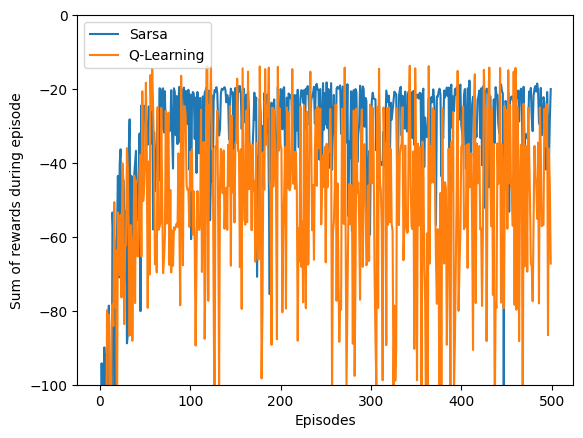

In [ ]:
print('Environment representation:')
print_env()

# episodes of each run
episodes = 500

# perform 10 independent runs
runs = 10

rewards_sarsa = np.zeros(episodes)
rewards_q_learning = np.zeros(episodes)
for r in tqdm(range(runs)):  # every time I start with a new q_table (I will print only the last one)
    q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    q_q_learning = np.copy(q_sarsa)
    for i in range(0, episodes):
        # cut off the value by -100 to draw the figure more elegantly
        # rewards_sarsa[i] += max(sarsa(q_sarsa), -100)
        # rewards_q_learning[i] += max(q_learning(q_q_learning), -100)
        rewards_sarsa[i] += sarsa(q_sarsa)
        rewards_q_learning[i] += q_learning(q_q_learning)

# averaging over independent runs
rewards_sarsa /= runs
rewards_q_learning /= runs

# display optimal policy
print('Sarsa Optimal Policy:')
opt_sarsa = print_optimal_policy(q_sarsa)
print('Sarsa optimal path (label \'A\'):')
print_env(opt_sarsa, 'A')
print('Q-Learning Optimal Policy:')
opt_q = print_optimal_policy(q_q_learning)
print('Q-learning optimal path (label \'Q\'):')
print_env(opt_q, 'Q')

# draw reward curves
plt.plot(rewards_sarsa, label='Sarsa')
plt.plot(rewards_q_learning, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.ylim([-100, 0])
plt.legend()

plt.show()
plt.close()

## TD fixed point

We want to describe the quantity of interest (the value or q-function) with a smaller number of "degrees of
freedom" than the number of all possible state $\vert \mathcal{S}\vert$, and in order to do that we exploit a _parametrized functional form_.
This means that we will express our quantity of interest with a **parameter** $w \in \mathbb{R}^d$ (or better a vector of parameters) which
uniquely describe a particular function $f \in \mathcal{F}_w$.

Then our best approximation will of course belong to this space of functions $\mathcal{F}_w$ (given by the functions
that can be described by a particular paramter $w$), and indeed this is the "simplification" we are introducing in the
problem: we are searching in a smaller space $\mathcal{F}_w \subset \mathcal{F}$, reducing the dimensionality from
$\vert \mathcal{S}\vert$ to $d$, with $d<<\vert \mathcal{S}\vert$.

Consider the **linear** function space. Given the $d$ dimensional _fixed_ feature vector

$$ x(s) = (x_1(s), x_2(s), \dots, x_d(s)) $$

we want to find the best $w = (w_1, \dots, w_d)$ so that the prediction objective ($\overline{\text{VE}}$) is minimized, given the linear functional form: $\hat{v}(s, w)=w^\top x(s)$.

Recall that the prediction objective is the norm of the difference of our approximation and the true value-function,
weighted by a state distribution $\mu(s)$, i.e.:

$$\overline{\text{VE}}(w) = \sum_{s\in\mathcal{S}}\mu(s)[v_\pi(s) - \hat{v}(s, w)]^2$$

A simple strategy to minimize this objective is the SGD algorithm, which yields the update:

$$ w_{t+1} = w_t + \alpha[U_t - \hat{v}(s_t, w_t)]x(s_t)$$

since $\nabla_w\hat{v}(s, w) = x(s)$. Pay attention: for this update to hold exactly, the target $U_t$ must not depend on $w$!
Otherwise, the derivative of that term is also implied! If the latter is neglected, we call it a semi-gradient update.

TD algorithm uses bootstrapping, and therefore the target depends on the current estimate, which of
course depends on $w$. Thus we have a semi-gradient update, that does not converges to the global optimum (which is
attained by following the Monte Carlo algorithm, for example), but to the so-called _TD fixed point_.

It can be proved that the prediction objective at the TD fixed point is lower bounded by:

$$ \overline{\text{VE}}(w_{\text{TD}}) \leq \frac{1}{1-\gamma}\overline{\text{VE}}(w) $$

We will verify how bad the _TD fixed point_ can be in the case of "maximum bootstrapping", i.e. $\gamma = 1$, (in which the prediction objective can grow unbounded) with the 1000-state Random Walk environment.

1000-state **Random Walk environment**:
- Start in state 500
- Actions: left or right randomly (policy is embedded in the environment)
- For every transition there is an equal probability of terminating in the next 100 states (in the direction of the
action), always with $0$ reward. If there are less than 100 states the probability is accumulated in the last state.
- Termination on the left: -1 reward
- Termination on the right: +1 reward

In [ ]:
# of states except for terminal states
N_STATES = 1000

# all states
STATES = np.arange(1, N_STATES + 1)

# start from a central state
START_STATE = 500

# terminal states
END_STATES = [0, N_STATES + 1]

# possible actions
ACTION_LEFT = -1
ACTION_RIGHT = 1
ACTIONS = [ACTION_LEFT, ACTION_RIGHT]

# maximum stride for an action
STEP_RANGE = 100


def compute_true_value():
    # true state value, just a promising guess
    true_value = np.arange(-1001, 1003, 2) / 1001.0
    assert (np.arange(-1001, 1003, 2) == np.arange(-1001, 1002, 2)).all()

    # Dynamic programming to find the true state values, based on the promising guess above
    # Assume all rewards are 0, given that we have already given value -1 and 1 to terminal states
    while True:
        old_value = np.copy(true_value)
        for state in STATES:
            true_value[state] = 0
            for action in ACTIONS:
                for step in range(1, STEP_RANGE + 1):
                    step *= action  # step with sign
                    next_state = state + step
                    next_state = max(min(next_state, N_STATES + 1), 0)  # to clip the boundaries
                    # asynchronous update for faster convergence
                    # probability is 1/200 because of random action - estimating v_\pi!
                    true_value[state] += 1.0 / (2 * STEP_RANGE) * true_value[next_state]
        error = np.sum(np.abs(old_value - true_value))
        if error < 1e-2:
            break
    # correct the state value for terminal states to 0
    true_value[0] = true_value[-1] = 0

    return true_value


# take an @action at @state, return new state and reward for this transition
def step(state, action):
    step = np.random.randint(1, STEP_RANGE + 1)
    step *= action
    state += step
    state = max(min(state, N_STATES + 1), 0)
    if state == 0:
        reward = -1
    elif state == N_STATES + 1:
        reward = 1
    else:
        reward = 0
    return state, reward


# get an action, following random policy
def get_action():
    if np.random.binomial(1, 0.5) == 1:
        return 1
    return -1

In [ ]:
# a wrapper class for aggregation value function
class ValueFunction:
    # @num_of_groups: # of aggregations
    def __init__(self, num_of_groups):
        self.num_of_groups = num_of_groups  #  dimension of the feature vector d
        self.group_size = N_STATES // num_of_groups

        # thetas
        self.params = np.zeros(num_of_groups)

    # get the value of @state
    def value(self, state):
        if state in END_STATES:
            return 0
        group_index = (state - 1) // self.group_size
        return self.params[group_index]  # collective value of the group (to which the state belongs) is returned!

    # update parameters
    # @delta: step size * (target - old estimation)
    # @state: state of current sample
    def update(self, delta, state):
        group_index = (state - 1) // self.group_size
        self.params[group_index] += delta

We want to understand the role of the TD fixed point, so we need to compare its prediction objective to the global
optimum. To reach the latter point, we use the Monte Carlo algorithm (which is unbiased, and its target does not depend
on $w$).

SGD for **Monte Carlo** scheme:
$$ w_{t+1} = w_t + \alpha[G_t - \hat{v}(s_t, w_t)]\nabla_w\hat{v}(s_t, w_t) $$

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:25<00:00, 3947.16it/s]


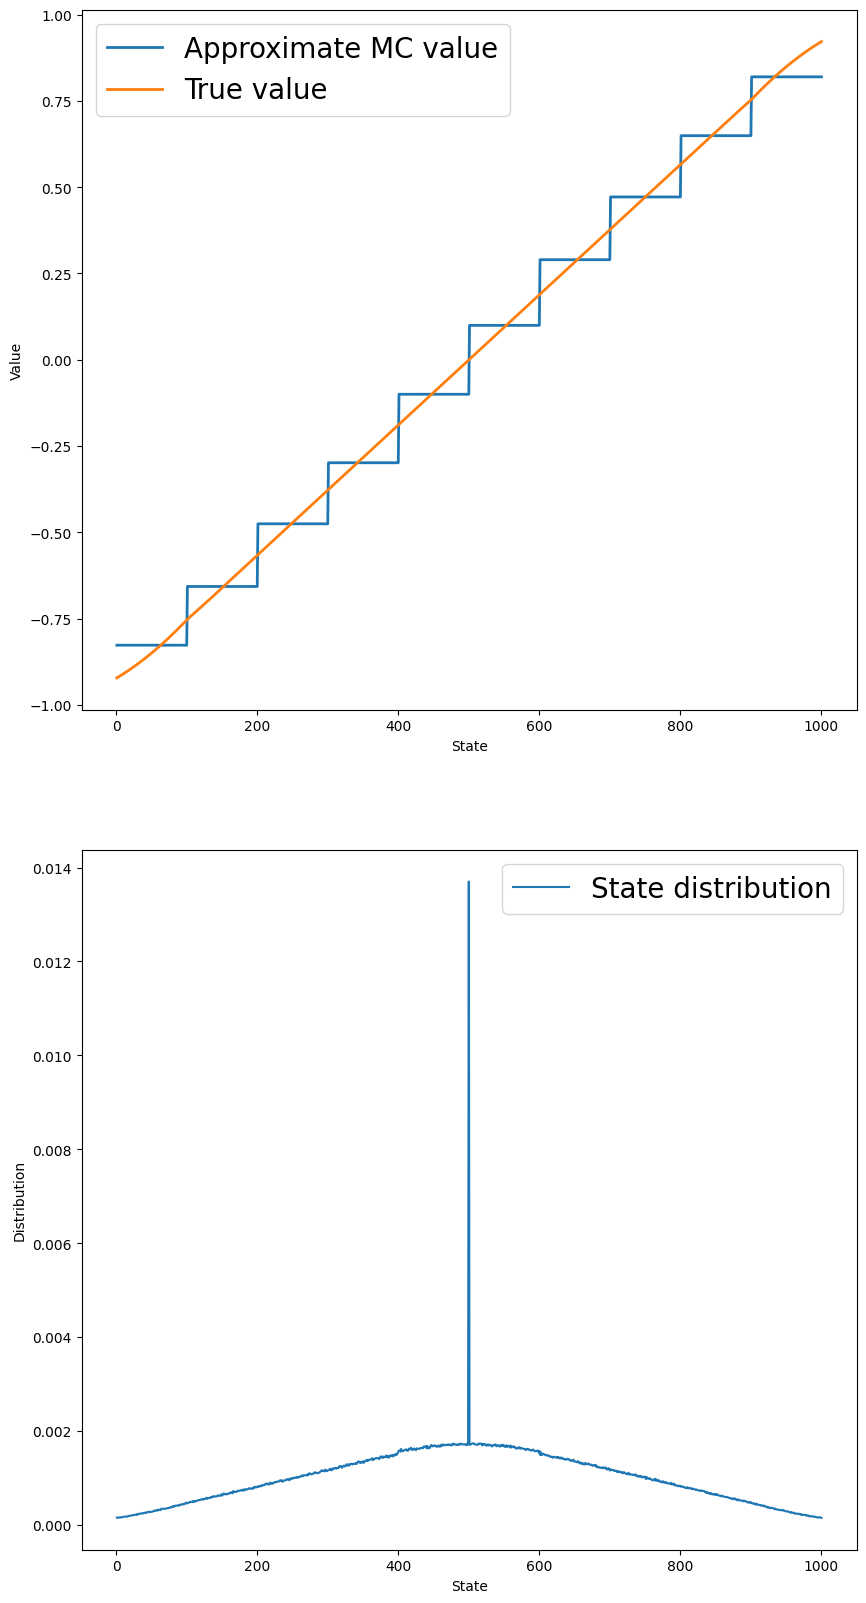

In [ ]:
# gradient Monte Carlo algorithm
# @value_function: an instance of class ValueFunction
# @alpha: step size
# @distribution: array to store the distribution statistics
def gradient_monte_carlo(value_function, alpha, distribution=None):
    state = START_STATE
    trajectory = [state]

    # We assume gamma = 1, so return is just the same as the latest reward
    reward = 0.0
    while state not in END_STATES:
        action = get_action()
        next_state, reward = step(state, action)  # reward keeps updating!
        trajectory.append(next_state)
        state = next_state

    # Gradient update for each state in this trajectory
    for state in trajectory[:-1]:  # parse the trajectory backward
        delta = alpha * (reward - value_function.value(state))  # Monte Carlo!
        value_function.update(delta, state)
        if distribution is not None:
            distribution[state] += 1  # also empirical distribution is provided


true_value = compute_true_value()

episodes = int(1e5)
alpha = 2e-5

# we have 10 aggregations in this example, each has 100 states
value_function = ValueFunction(10)
distribution = np.zeros(N_STATES + 2)
for ep in tqdm(range(episodes)):
    gradient_monte_carlo(value_function, alpha, distribution)

distribution /= np.sum(distribution)  # normalize distribution
state_values = [value_function.value(i) for i in STATES]  # get values for each state

plt.figure(figsize=(10, 20))

plt.subplot(2, 1, 1)
plt.plot(STATES, state_values, label='Approximate MC value', linewidth=2)
plt.plot(STATES, true_value[1: -1], label='True value', linewidth=2)
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(prop={"size":20})

plt.subplot(2, 1, 2)
plt.plot(STATES, distribution[1: -1], label='State distribution')
plt.xlabel('State')
plt.ylabel('Distribution')
plt.legend(prop={"size":20})

plt.show()
plt.close()



SGD for **TD[n]** method:
$$w_{t+1} = w_t + \alpha[r+r'+r''+\dots+\hat{v}(s_{t+n}, w_t)-\hat{v}(s_t, w_t)]\nabla_w\hat{v}(s_t, w_t) $$

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:32<00:00, 3084.56it/s]


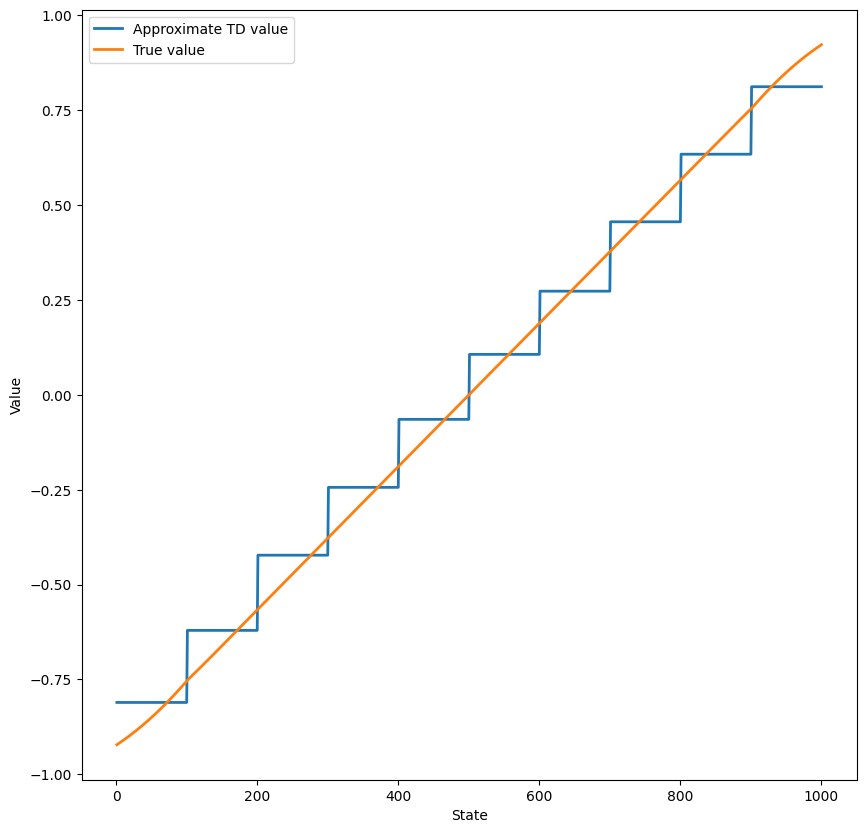

In [ ]:
# semi-gradient n-step TD algorithm
# @valueFunction: an instance of class ValueFunction
# @n: # of steps
# @alpha: step size
def semi_gradient_temporal_difference(value_function, n, alpha):
    # initial starting state
    state = START_STATE

    # arrays to store states and rewards for an episode
    # space isn't a major consideration, so I didn't use the mod trick
    states = [state]
    rewards = [0]  # never using these values

    # track the time
    time = 0

    # the length of this episode
    T = float('inf')
    while True:
        # go to next time step
        time += 1

        if time < T:
            # choose an action randomly
            action = get_action()
            next_state, reward = step(state, action)

            # store new state and new reward
            states.append(next_state)
            rewards.append(reward)

            if next_state in END_STATES:
                T = time

        # get the time of the state to update
        update_time = time - n
        if update_time >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(update_time + 1, min(T, update_time + n) + 1):
                returns += rewards[t]
            # add state value to the return
            if update_time + n <= T:  # bootstrapping
                # I believe < is correct, not <=, but since value returns 0 in END_STATES is actually the same
                returns += value_function.value(states[update_time + n])
            state_to_update = states[update_time]
            # update the value function
            if not state_to_update in END_STATES:
                delta = alpha * (returns - value_function.value(state_to_update))
                value_function.update(delta, state_to_update)
        if update_time == T - 1:
            break
        state = next_state


episodes = int(1e5)
alpha = 2e-4
value_function = ValueFunction(10)
for ep in tqdm(range(episodes)):
    semi_gradient_temporal_difference(value_function, 5, alpha)

stateValues = [value_function.value(i) for i in STATES]

plt.figure(figsize=(10, 10))

plt.plot(STATES, stateValues, label='Approximate TD value', linewidth=2)
plt.plot(STATES, true_value[1: -1], label='True value', linewidth=2)
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()